<a href="https://colab.research.google.com/github/Posfay/Named-Entity-Recognition-using-BERT/blob/main/NER_Data_Preprocessing_and_Tokenization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://hlt.sztaki.hu/resources/hunnerwiki/huwiki.1.ner.tsv.gz

http://hlt.sztaki.hu/resources/hunnerwiki/huwiki.2.ner.tsv.gz

http://hlt.sztaki.hu/resources/hunnerwiki/huwiki.3.ner.tsv.gz

http://hlt.sztaki.hu/resources/hunnerwiki/huwiki.4.ner.tsv.gz

## Installs and imports

In [ ]:
!pip install datasets -q
!pip install tokenizers -q
!pip install transformers -q
!pip install sklearn
!pip install fast_ml

     |████████████████████████████████| 451 kB 14.9 MB/s 
     |████████████████████████████████| 182 kB 69.3 MB/s 
     |████████████████████████████████| 115 kB 64.6 MB/s 
     |████████████████████████████████| 212 kB 65.2 MB/s 
     |████████████████████████████████| 127 kB 73.1 MB/s 
     |████████████████████████████████| 7.6 MB 14.4 MB/s 
     |████████████████████████████████| 5.5 MB 14.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=21a372e2bf4da41cf57596591ef23297085da867534bdeee84f62746da42e9cf
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.1 MB/s 


In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from datasets import Dataset, Sequence, ClassLabel, Value, load_dataset, load_from_disk

from transformers import AutoTokenizer

## Creating the dataframe

In [ ]:
# Downloading the data
df1 = pd.read_csv('http://hlt.sztaki.hu/resources/hunnerwiki/huwiki.1.ner.tsv.gz', compression='gzip', names = ["tokens", 1, 2, 3, 4, "ner_tags"], sep='\t', skip_blank_lines=False, quoting=csv.QUOTE_NONE)
df1 = df1.drop(columns=[1, 2, 3, 4])
df2 = pd.read_csv('http://hlt.sztaki.hu/resources/hunnerwiki/huwiki.2.ner.tsv.gz', compression='gzip', names = ["tokens", 1, 2, 3, 4, "ner_tags"], sep='\t', skip_blank_lines=False, quoting=csv.QUOTE_NONE)
df2 = df2.drop(columns=[1, 2, 3, 4])
df3 = pd.read_csv('http://hlt.sztaki.hu/resources/hunnerwiki/huwiki.3.ner.tsv.gz', compression='gzip', names = ["tokens", 1, 2, 3, 4, "ner_tags"], sep='\t', skip_blank_lines=False, quoting=csv.QUOTE_NONE)
df3 = df3.drop(columns=[1, 2, 3, 4])
df4 = pd.read_csv('http://hlt.sztaki.hu/resources/hunnerwiki/huwiki.4.ner.tsv.gz', compression='gzip', names = ["tokens", 1, 2, 3, 4, "ner_tags"], sep='\t', skip_blank_lines=False, quoting=csv.QUOTE_NONE)
df4 = df4.drop(columns=[1, 2, 3, 4])

In [ ]:
df = pd.concat([df1, df2, df3, df4])

In [ ]:
print(df.shape)
df.head()

(20408549, 2)


,tokens,ner_tags
0,A,O
1,céljuk,O
2,",",O
3,hogy,O
4,biztosítsák,O


In [ ]:
NER_tag_names = df.groupby(df["ner_tags"]).groups.keys()
NER_tag_names

dict_keys(['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'])

In [ ]:
# Reordering the tags for easier interpretation
NER_tag_names = ['O', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', 'B-MISC', 'I-MISC']

## NER tag frequency figures

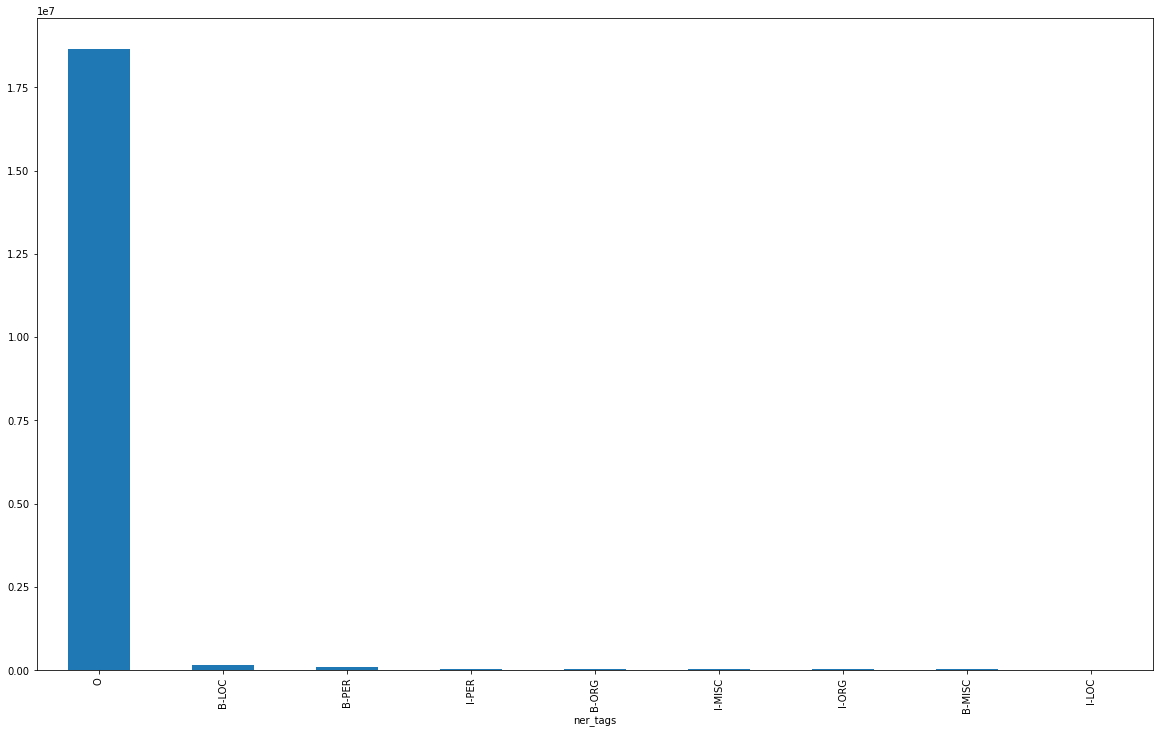

In [ ]:
NER_tag_values = df.groupby(df["ner_tags"]).size()
fig, ax = plt.subplots(1, figsize=(20, 12))
NER_tag_values.sort_values(ascending=False, inplace=True)
NER_tag_values.plot(kind='bar', ax=ax)

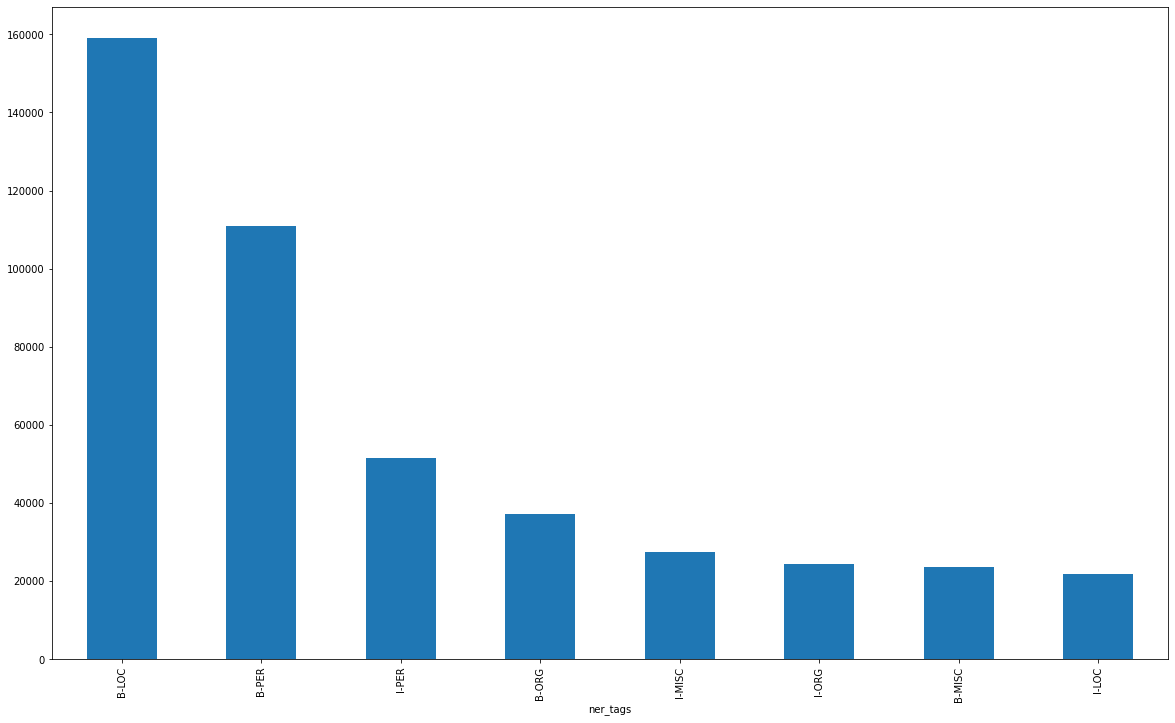

In [ ]:
# frequency without the most frequent
fig, ax = plt.subplots(1, figsize=(20, 12))
NER_tag_values[1:].plot(kind='bar', ax=ax)

## Converting the dataframe into a dataset
Grouping sequences into individual rows, as the tokenization procedure and the model both uses sequences as inputs instead of single tokens.

In [ ]:
ner_array = df.to_numpy()

In [ ]:
ner_array.shape

(20408549, 2)

In [ ]:
array_text_data = []

In [ ]:
#Finding the index of every sentence end
sentence_end_list = df[df["tokens"].isnull()].index.tolist() #4

In [ ]:
#Calculating the index of every sentence start
sentece_start_list = sentence_end_list[0:-1]
sentece_start_list = [x+1 for x in sentece_start_list]
sentece_start_list.insert(0, 0)

In [ ]:
for i in range(0, len(sentece_start_list)):
  sentence_and_tags = ner_array[sentece_start_list[i]:sentence_end_list[i]].reshape(-1)
  #After flattening, the sentence words and the ner tags follow each other in turn
  a =[[x for x in sentence_and_tags[0:len(sentence_and_tags):2]], [x for x in sentence_and_tags[1:len(sentence_and_tags):2]]]
  array_text_data.append(a)

In [ ]:
dataframe = pd.DataFrame(array_text_data, columns=["tokens", "ner_tags"])
print(dataframe.shape)
dataframe.head()

(1299984, 2)


,tokens,ner_tags
0,"[A, céljuk, ,, hogy, biztosítsák, ,, hogy, a, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[Figyelem, !]","[O, O]"
2,"[Mivel, nem, jogászok, által, készített, hitel...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[Az, eredeti, 1.2, változat, a, a, különbség, ...","[O, O, O, O, O, O, O, O, O, O, O, O]"
4,"[Jelen, licenc, célja, egy, olyan, kézikönyv, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
dataset = Dataset.from_pandas(dataframe)

In [ ]:
dataset[69]

{'tokens': ['A',
  'tagcsere',
  'után',
  'stílust',
  'váltva',
  'az',
  'együttes',
  'hamar',
  'talpra',
  'állt',
  ',',
  'az',
  'új',
  'felállás',
  'Prágában',
  'sikeresen',
  'mutatkozott',
  'be',
  '.'],
 'ner_tags': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-LOC',
  'O',
  'O',
  'O',
  'O']}

In [ ]:
new_features = dataset.features.copy()
new_features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [ ]:
new_features["ner_tags"] = Sequence(ClassLabel(names=NER_tag_names))
dataset = dataset.cast(new_features)

Casting the dataset:   0%|          | 0/1300 [00:00<?, ?ba/s]

In [ ]:
dataset[2]

In [ ]:
dataframe.head()

## Tokenization
Performing tokenization on the data using huBERT, a Hungarian transformer model, like BERT base.

In [ ]:
pretokenized_ds = load_from_disk("sztaki_full_pretokenized")
pretokenized_df = pd.DataFrame(pretokenized_ds)

In [ ]:
# Removing every None from the tokens and ner tags
# because they break the tokenization
for i, row in pretokenized_df.iterrows():
    row["tokens"] = [x for x in row["tokens"] if x is not None]
    row["ner_tags"] = [x for x in row["ner_tags"] if x is not None]

In [ ]:
pretokenized_ds_mod = Dataset.from_pandas(pretokenized_df)
pretokenized_ds_mod

In [ ]:
new_features_pt = pretokenized_ds.features.copy()
new_features_pt

In [ ]:
# Converting back to Dataset (since the model is expecting it as such)
pretokenized_ds_mod = pretokenized_ds_mod.cast(new_features_pt)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("SZTAKI-HLT/hubert-base-cc")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Get the values for input_ids, attention_mask, adjusted labels
def tokenize_adjust_labels(all_samples_per_split):
  # tokenizing the dataset
  tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True, truncation=True)
  
  # labels replacing ner_tags in the dataset
  total_adjusted_labels = []
  
  # correcting the labels (ner_tags) for every token because of subword tokenization
  for k in range(0, len(tokenized_samples["input_ids"])):
    prev_wid = -1
    word_ids_list = tokenized_samples.word_ids(batch_index=k)
    existing_label_ids = all_samples_per_split["ner_tags"][k]
    i = -1
    # labels replacing ner_tags in the current sequence
    adjusted_label_ids = []
   
    for word_idx in word_ids_list:
      # Subword tokens have a word id that is None. We set the label to -100 
      # so they are automatically ignored in the loss function.
      if word_idx is None:
        adjusted_label_ids.append(-100)
      # if next token is a subword token, mark with same label (ner_tag)
      elif word_idx != prev_wid:
        i = i + 1
        adjusted_label_ids.append(existing_label_ids[i])
        prev_wid = word_idx
      # if next token is a new word, add the correct label to the list
      else:
        # label_name = label_names[existing_label_ids[i]]
        adjusted_label_ids.append(existing_label_ids[i])
    
    # add current sequence's corrected labels to the dataset
    total_adjusted_labels.append(adjusted_label_ids)
  
  # add adjusted labels to the tokenized dataset
  tokenized_samples["labels"] = total_adjusted_labels
  return tokenized_samples

In [ ]:
tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True, batch_size=100, remove_columns=['tokens', 'ner_tags'])
tokenized_dataset

In [ ]:
tokenized_dataset.save_to_disk("sztaki_full_hun_tokenized")

In [ ]:
# checking an example record from the Dataset
example_id = 111

In [ ]:
tokenized_dataset[example_id]["labels"]

In [ ]:
tokenizer.convert_ids_to_tokens(tokenized_dataset[example_id]["input_ids"])